In [1]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from utils import *
from model import *
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
with open("data/train.pkl", "rb") as f:
    train_data = pickle.load(f)
len(train_data)

2939

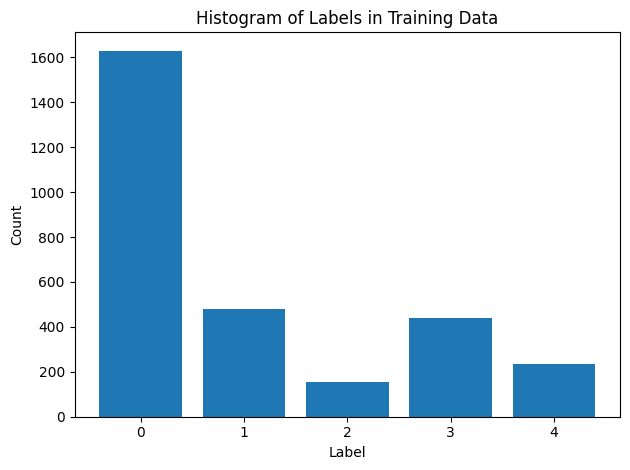

In [3]:
histogram = histogram(train_data)
plt.bar(histogram.keys(), histogram.values())
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Histogram of Labels in Training Data")
plt.tight_layout()
plt.show()

In [4]:
lengths = len_histogram(train_data)
df = pd.DataFrame([{
    "Dataset length": len(train_data),
    "Min sequence length": min(lengths.keys()),
    "Max sequence length": max(lengths.keys()),
    "Mean sequence length": np.mean(list(lengths.keys())),
    "Unique lengths:": len(list(lengths.keys()))
}])
df

,Dataset length,Min sequence length,Max sequence length,Mean sequence length,Unique lengths:
0,2939,4,6308,861.128205,819


In [5]:
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

We split the dataset into 85% training set and 15% validation set.

In [6]:
batch_size = 64
train_dataset = SequenceDataset(train_data)
val_dataset = SequenceDataset(val_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Training
We trained a total of eight sequence classification models, evenly split between two recurrent architectures:
- 4 LSTM-based classifiers
- 4 GRU-based classifiers

All models use a hidden size of 128. Training was performed with the following settings:
- Batch size: 64
- Learning rate: 3e-4
- Maximum epochs: 100
- Early stopping: Triggered if validation accuracy does not improve for 10 consecutive epochs (patience=10)

In [8]:
models = [
    LSTMClassifier(input_size=1, hidden_size=128, output_size=len(histogram), num_layers=1),
    LSTMClassifier(input_size=1, hidden_size=128, output_size=len(histogram), num_layers=2),
    LSTMClassifier(input_size=1, hidden_size=128, output_size=len(histogram), num_layers=1, bidirectional=True),
    LSTMClassifier(input_size=1, hidden_size=128, output_size=len(histogram), num_layers=2, bidirectional=True),
    GRUClassifier(input_size=1, hidden_size=128, output_size=len(histogram), num_layers=1),
    GRUClassifier(input_size=1, hidden_size=128, output_size=len(histogram), num_layers=2),
    GRUClassifier(input_size=1, hidden_size=128, output_size=len(histogram), num_layers=1, bidirectional=True),
    GRUClassifier(input_size=1, hidden_size=128, output_size=len(histogram), num_layers=2, bidirectional=True),
]

In [9]:
results = measure_performance(models, train_loader, val_loader, device, epochs=100, lr=3e-4, patience=10, path="models/")

------------------------------ Training model 0 ------------------------------


/home/atarsander/University/Neural-Networks/lab5/utils.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq).unsqueeze(-1).float() for seq in sequences]


Epoch 5: Loss = 1.1745 | Train accuracy = 55.36% | Val accuracy = 56.01%
Epoch 10: Loss = 1.0502 | Train accuracy = 61.77% | Val accuracy = 65.31%
Epoch 15: Loss = 1.0045 | Train accuracy = 62.29% | Val accuracy = 65.99%
Epoch 20: Loss = 0.9346 | Train accuracy = 64.37% | Val accuracy = 67.12%
Epoch 25: Loss = 0.8844 | Train accuracy = 67.33% | Val accuracy = 68.71%
Epoch 30: Loss = 0.8167 | Train accuracy = 70.30% | Val accuracy = 71.88%
Epoch 35: Loss = 0.8150 | Train accuracy = 69.22% | Val accuracy = 71.88%
Epoch 40: Loss = 0.7640 | Train accuracy = 72.06% | Val accuracy = 72.56%
Epoch 45: Loss = 0.7935 | Train accuracy = 71.38% | Val accuracy = 72.79%
Epoch 50: Loss = 0.6999 | Train accuracy = 73.86% | Val accuracy = 72.79%
Epoch 55: Loss = 0.6616 | Train accuracy = 75.78% | Val accuracy = 72.34%
Epoch 60: Loss = 0.6628 | Train accuracy = 76.42% | Val accuracy = 74.15%
Epoch 65: Loss = 0.6033 | Train accuracy = 78.98% | Val accuracy = 73.02%
Early stopping triggered
--------------

In [24]:
results = pd.DataFrame(results, columns=["Model", "Training accuracy", "Validation accuracy"])
results ["Training accuracy"] = results ["Training accuracy"].apply(lambda x: f"{round(float(x.strip('%')), 2)}%")
results ["Validation accuracy"] = results ["Validation accuracy"].apply(lambda x: f"{round(float(x.strip('%')), 2)}%")
results

,Model,Training accuracy,Validation accuracy
0,"LSTMClassifier(\n (lstm): LSTM(1, 128, batch_...",79.7%,73.7%
1,"LSTMClassifier(\n (lstm): LSTM(1, 128, num_la...",74.66%,72.56%
2,"LSTMClassifier(\n (lstm): LSTM(1, 128, batch_...",83.67%,75.28%
3,"LSTMClassifier(\n (lstm): LSTM(1, 128, num_la...",94.2%,77.55%
4,"GRUClassifier(\n (gru): GRU(1, 128, batch_fir...",83.55%,79.14%
5,"GRUClassifier(\n (gru): GRU(1, 128, num_layer...",92.83%,81.41%
6,"GRUClassifier(\n (gru): GRU(1, 128, batch_fir...",85.55%,78.68%
7,"GRUClassifier(\n (gru): GRU(1, 128, num_layer...",88.39%,78.23%


The best performance (validation accuracy) was achieved by GRU Classifier with 2 layers (model 5). The worst performance was achieved by LSTM Classifier with 1 layer.
### Further experiments
We took the GRU Classifier with 2 layers as our final architecture type and conducted more experiments with different learning rates and hidden sizes.

In [ ]:
final_models = [
    GRUClassifier(
        input_size=1, hidden_size=128, output_size=len(histogram), num_layers=2
    ),
    GRUClassifier(
        input_size=1, hidden_size=64, output_size=len(histogram), num_layers=2
    ),
    GRUClassifier(
        input_size=1, hidden_size=64, output_size=len(histogram), num_layers=2
    ),
]
learning_rates = [3e-3, 3e-3, 3e-4]

In [ ]:
# results_final = test_models(final_models, train_loader, val_loader, device, learning_rates)

------------------------------ Training model 0 ------------------------------


/home/atarsander/University/Neural-Networks/lab5/utils.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq).unsqueeze(-1).float() for seq in sequences]


Epoch 5: Loss = 0.0249 | Train accuracy = 99.40% | Val accuracy = 80.27%


KeyboardInterrupt: 

In [75]:
results_final = []
for i, model in enumerate(final_models):
    model = torch.load(f"models/final_model_{i}.pth", map_location=device, weights_only=False)
    train_preds, train_labels = predict(model, train_loader, device)
    train_accuracy = evaluate(train_preds, train_labels)
    val_preds, val_labels = predict(model, val_loader, device)
    val_accuracy = evaluate(val_preds, val_labels)
    results_final.append((str(model), train_accuracy, val_accuracy))

/home/atarsander/University/Neural-Networks/lab5/utils.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq).unsqueeze(-1).float() for seq in sequences]


In [76]:
df_final = pd.DataFrame(results_final, columns=["Model", "Training accuracy", "Validation accuracy"])
# df_final["Training accuracy"] = df_final["Training accuracy"].apply(
#     lambda x: f"{x.item():.2f}%" if torch.is_tensor(x) else f"{float(x):.2f}%"
# )

# df_final["Validation accuracy"] = df_final["Validation accuracy"].apply(
#     lambda x: f"{x.item():.2f}%" if torch.is_tensor(x) else f"{float(x):.2f}%"
# )
df_final

,Model,Training accuracy,Validation accuracy
0,"GRUClassifier(\n (gru): GRU(1, 128, num_layer...",tensor(0.9896),tensor(0.8027)
1,"GRUClassifier(\n (gru): GRU(1, 64, num_layers...",tensor(0.9339),tensor(0.8163)
2,"GRUClassifier(\n (gru): GRU(1, 64, num_layers...",tensor(0.8483),tensor(0.8005)


In [77]:
final_model = final_models[1]

In [78]:
with open("data/test_no_target.pkl", "rb") as f:
    test_data = pickle.load(f)
print(len(test_data))

1103


In [81]:
test_dataset = TestDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_test)

In [83]:
predictions = predict_final(final_model, test_dataloader, device)

/tmp/ipykernel_105811/768936045.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq).unsqueeze(-1).float() for seq in sequences]


In [84]:
pred = pd.DataFrame(predictions)
print(len(pred))
pred.to_csv("pred.csv", index=False, header=False)

1103


## Conclusions
- The best performance in the initial experiment was achieved by GRU Classifier with 2 layers, with validation accuracy of 81.41%.
- In the following experiment the result was slightly improved for the same classifier with smaller hidden size (64).
- All of the GRU model's showed better generalization, train/val stability and lower overfitting risk than LSTM's.
- Bidirectional LSTM with 2 layers (model 3) showed significant overfitting with 94.2% traning accuracy and 77.55% validation accuracy.
- During every model's training it was necessary to use early stopping before target epochs=100, because of falling validation accuracy (patience=10).